# Gradient Descent on Neural Networks

In [1]:
import numpy as np
import matplotlib.pyplot as plt

logistic = lambda u: 1/(1+np.exp(-u))
step = lambda u: 0.5*(1+np.sign(u))

def get_logistic_loss(u, z):
    """
    Compute the logistic loss

    Parameters
    ----------
    u: ndarray(N)
        Input to logistic function
    z: ndarray(N)
        Target values
    """
    f = logistic(u)
    return np.sum(-z*np.log(f) - (1-z)*np.log(1-f))

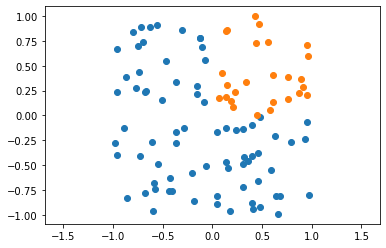

In [2]:
def get_disc_points(N=100):
    X = np.random.randn(100, 2)
    d = np.sqrt(np.sum(X**2, axis=1))
    z = np.array(d < 1, dtype=float)
    return X, z

def get_AND_points(N=100):
    X = np.random.rand(N, 2)*2-1
    z = np.array((X[:, 0] >= 0)*(X[:, 1] >= 0), dtype=float)
    return X, z

def get_OR_points(N=100):
    X = np.random.rand(N, 2)*2-1
    z = np.array((X[:, 0] >= 0) + (X[:, 1] >= 0), dtype=float)
    return X, z

np.random.seed(0)
X, z = get_AND_points()
plt.scatter(X[z==0, 0], X[z==0, 1])
plt.scatter(X[z==1, 0], X[z==1, 1])
plt.axis("equal");

In [3]:
def plot_net(X, z, mynet, res=100, subplots=2):
    rg = [np.min(X[:, 0]), np.max(X[:, 0])]
    dr = rg[1] - rg[0]
    pixx = np.linspace(rg[0], rg[1], res)
    rg = [np.min(X[:, 1]), np.max(X[:, 1])]
    dr = rg[1]- rg[0]
    pixy = np.linspace(rg[0], rg[1], res)
    xx, yy = np.meshgrid(pixx, pixy)
    I = mynet(xx.flatten(), yy.flatten())
    I = np.reshape(I, xx.shape)
    
    plt.subplot(1, subplots, 1)
    plt.imshow(I, cmap='gray', extent=(pixx[0], pixx[-1], pixy[-1], pixy[0]), vmin=0, vmax=1)
    plt.scatter(X[z == 0, 0], X[z == 0, 1], c='C0')
    plt.scatter(X[z == 1, 0], X[z == 1, 1], c='C1')
    plt.gca().invert_yaxis()
    plt.title("Output Layer")
    plt.subplot(1, subplots, 2)
    plt.imshow(I > 0.5, cmap='gray', extent=(pixx[0], pixx[-1], pixy[-1], pixy[0]), vmin=0, vmax=1)
    
    pred = mynet(X[:, 0], X[:, 1]) > 0.5
    plt.scatter(X[(z == 0)*(pred == 0), 0], X[(z == 0)*(pred == 0), 1], c='C0')
    plt.scatter(X[(z == 0)*(pred == 1), 0], X[(z == 0)*(pred == 1), 1], c='C0', marker='x')
    plt.scatter(X[(z == 1)*(pred == 0), 0], X[(z == 1)*(pred == 0), 1], c='C1', marker='x')
    plt.scatter(X[(z == 1)*(pred == 1), 0], X[(z == 1)*(pred == 1), 1], c='C1')
    plt.gca().invert_yaxis()
    num_correct = np.sum((z==0)*(pred==0)) + np.sum((z==1)*(pred==1))
    perc = 100*num_correct/X.shape[0]
    plt.title("{} Correct ({}%)".format(num_correct, perc))

    
def plot_logistic_regression_predictions(X1, X2, a, b, c, draw_lines=False):
    plt.scatter(X1[:, 0], X1[:, 1])
    plt.scatter(X2[:, 0], X2[:, 1])
    X = np.concatenate((X1, X2), axis=0)
    xmin = np.min(X, axis=0)
    xmax = np.max(X, axis=0)
    iv = max(xmax[1]-xmin[1], xmax[0]-xmin[0])
    
    p0 = -c*np.array([a, b])/(a**2 + b**2)
    v = np.array([-b, a])
    mag = np.sqrt(np.sum(v**2))
    if mag > 0:
        v = v/mag
        p = p0 - 2*iv*v
        q = p0 + 2*iv*v
        plt.plot([p[0], q[0]], [p[1], q[1]])
        rg = xmax[0] - xmin[0]
        plt.xlim([xmin[0]-0.2*rg, xmax[0]+0.2*rg])
        rg = xmax[1] - xmin[1]
        plt.ylim([xmin[1]-0.2*rg, xmax[1]+0.2*rg])

        wrong = 0
        for x in X1:
            y = logistic(a*x[0] + b*x[1] + c)
            proj = p0 + np.sum(v*(x-p0))*v
            if draw_lines:
                plt.plot([x[0], proj[0]], [x[1], proj[1]], c='C0', linewidth=1, linestyle='--')
            if y > 0.5:
                plt.scatter([x[0]], [x[1]], 200, c='C0', marker='x')
                wrong += 1
        for x in X2:
            y = logistic(a*x[0] + b*x[1] + c)
            proj = p0 + np.sum(v*(x-p0))*v
            if draw_lines:
                plt.plot([x[0], proj[0]], [x[1], proj[1]], c='C1', linewidth=1, linestyle='--')
            if y < 0.5:
                plt.scatter([x[0]], [x[1]], 200, c='C1', marker='x')
                wrong += 1

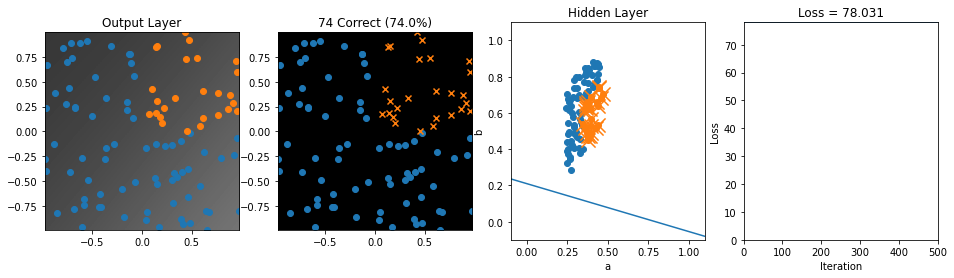

In [4]:
plot_animation=False
np.random.seed(4)
A = np.random.randn(2, 2)
B = np.random.randn(2)
c = np.random.randn(3)

def neuralnet(A, B, c, x, y):
    in1 = np.array([x.flatten(), y.flatten()])
    layer1 = logistic(A.dot(in1) + c[0:2][:, None])
    layer2 = logistic(B.dot(layer1) + c[2])
    return layer1, layer2

n_iters = 500
alpha = 0.02
losses = []

plt.figure(figsize=(16, 4))

plot_it = 0
for it in range(n_iters):
    layer1, layer2 = neuralnet(A, B, c, X[:, 0], X[:, 1])
    
    ## TODO: Fill in code to do gradient descent and update A, B, and c
    
    layer1, layer2 = neuralnet(A, B, c, X[:, 0], X[:, 1])
    losses.append(get_logistic_loss(layer2, z))
    if it == n_iters-1 or (plot_animation and it%2 == 0):
        plt.clf()
        plot_net(X, z, lambda x, y: neuralnet(A, B, c, x, y)[-1], subplots=4)
        plt.subplot(1, 4, 3)
        X1 = np.array([layer1[0, z==0], layer1[1, z==0]]).T
        X2 = np.array([layer1[0, z==1], layer1[1, z==1]]).T
        plot_logistic_regression_predictions(X1, X2, B[0], B[1], c[-1])
        plt.xlim([-0.1, 1.1])
        plt.ylim([-0.1, 1.1])
        plt.xlabel("a")
        plt.ylabel("b")
        plt.title("Hidden Layer")
        plt.subplot(1, 4, 4)
        plt.plot(losses)
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        plt.xlim([0, n_iters])
        plt.ylim([0, np.max(losses)])
        plt.title("Loss = {:.3f}".format(losses[-1]))
        if plot_animation:
            plt.savefig("Iter{}.png".format(plot_it), bbox_inches='tight', facecolor='white')
            plot_it += 1
